In [131]:
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings
from tensorflow import keras
import os
import cv2
import pandas as pd
from keras.src.layers import Rescaling
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

warnings.filterwarnings('ignore')

Sequential = keras.models.Sequential
Conv2D = keras.layers.Conv2D
Flatten = keras.layers.Flatten
Dropout = keras.layers.Dropout
MaxPooling2D = keras.layers.MaxPooling2D
Dense = keras.layers.Dense
Input = keras.layers.Input
EarlyStopping = keras.callbacks.EarlyStopping
ReduceLROnPlateau = keras.callbacks.ReduceLROnPlateau
Layers = keras.layers
ImageDataGenerator = keras.preprocessing.image.ImageDataGenerator
BatchNormalization = keras.layers.BatchNormalization
CSVLogger = keras.callbacks.CSVLogger

In [132]:
train_path = 'data/training/train'
test_path = 'data/testing/test'
pred_path = 'data/prediction'
PLOT_SAVE_DIR = 'output/plot/v3/'
LOG_DIR = 'output/log/v3/'
MODEL_SAVE_PATH = 'output/model/v2/cnn_model_v2.keras'

IMAGE_SIZE = (150, 150)
BATCH_SIZE = 32
EPOCHS = 50

train_files = []
train_labels = []

test_files = []
test_labels = []

In [133]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator()

In [134]:
train_ds = train_datagen.flow_from_directory(
    train_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=True
)

test_ds = test_datagen.flow_from_directory(
    test_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=True
)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [135]:
for label in os.listdir(train_path):
    label_path = os.path.join(train_path, label)
    if os.path.isdir(label_path):
        for filename in os.listdir(label_path):
            train_files.append(filename)
            train_labels.append(label)

In [136]:
df_train_files = pd.DataFrame({
    "file": train_files,
    "label": train_labels
})

df_train_files.head()

,file,label
0,5109.jpg,forest
1,14621.jpg,forest
2,6366.jpg,forest
3,4565.jpg,forest
4,17472.jpg,forest


In [137]:
class_train_names = df_train_files["label"].unique().tolist()
print(class_train_names)

['forest', 'buildings', 'glacier', 'street', 'mountain', 'sea']


In [138]:
for label in os.listdir(test_path):
    label_path = os.path.join(test_path, label)
    if os.path.isdir(label_path):
        for filename in os.listdir(label_path):
            test_files.append(filename)
            test_labels.append(label)

In [139]:
df_test_files = pd.DataFrame({
    "file": test_files,
    "label": test_labels
})

df_test_files.head()

,file,label
0,23933.jpg,forest
1,23728.jpg,forest
2,24047.jpg,forest
3,23700.jpg,forest
4,24251.jpg,forest


In [140]:
class_test_names = df_test_files["label"].unique().tolist()
print(class_train_names)

['forest', 'buildings', 'glacier', 'street', 'mountain', 'sea']


In [141]:
def image_path(path):
    image_names = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            fullpath = os.path.join(dirname, filename)
            image_names.append(fullpath)
    return image_names


images_paths = image_path(pred_path)
len(images_paths)

7301

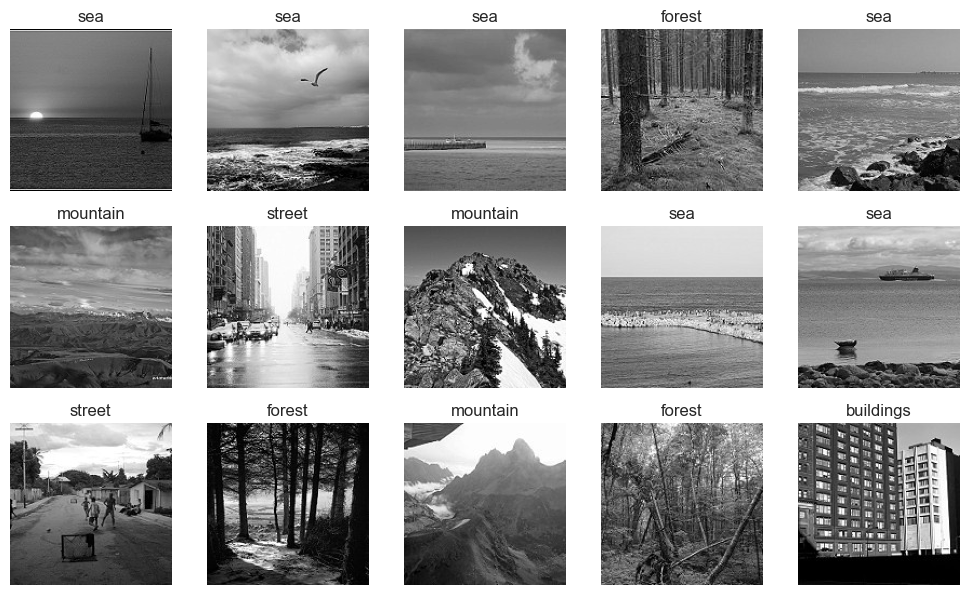

In [142]:
df_train_files = df_train_files.sample(frac=1).reset_index(drop=True)

plt.figure(figsize=(10, 10))

for i in range(15):
    if i >= len(df_train_files):
        break

    file_name = df_train_files.iloc[i]["file"]
    label = df_train_files.iloc[i]["label"]

    image_path = os.path.join(train_path, label, file_name)

    if not os.path.exists(image_path):
        print(f"File not found: {image_path}")
        continue

    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"Failed to read image: {image_path}")
        continue

    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(image, cmap="gray")
    plt.title(label)
    plt.axis("off")

plt.tight_layout()
plt.show()

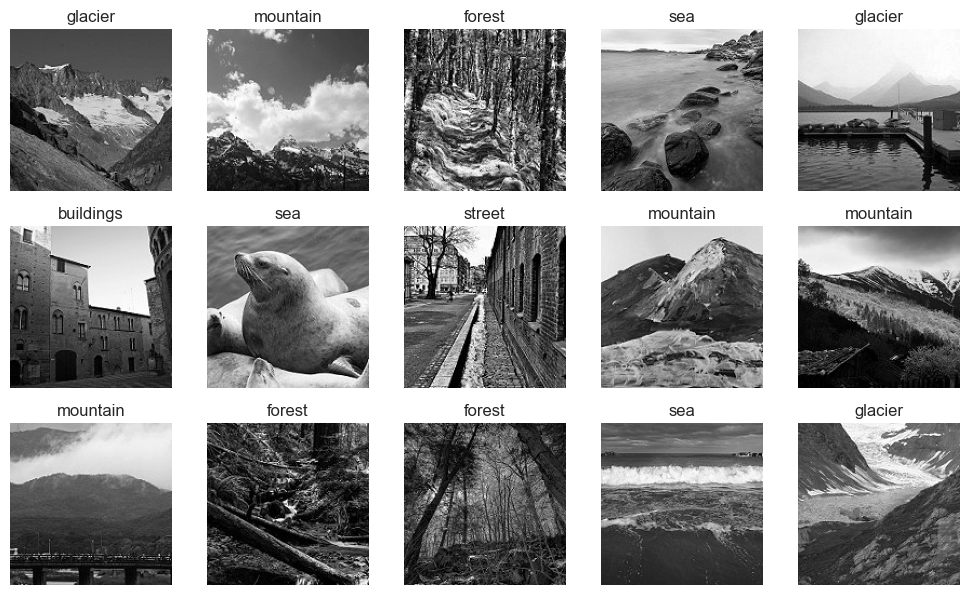

In [143]:
df_test_files = df_test_files.sample(frac=1).reset_index(drop=True)

plt.figure(figsize=(10, 10))

for i in range(15):
    if i >= len(df_train_files):
        break

    file_name = df_test_files.iloc[i]["file"]
    label = df_test_files.iloc[i]["label"]

    image_path = os.path.join(test_path, label, file_name)

    if not os.path.exists(image_path):
        print(f"File not found: {image_path}")
        continue

    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"Failed to read image: {image_path}")
        continue

    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(image, cmap="gray")
    plt.title(label)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [151]:
train_class_counts = {}
for class_name in os.listdir(train_path):
    class_dir = os.path.join(train_path, class_name)
    if os.path.isdir(class_dir):
        num_images = len(os.listdir(class_dir))
        train_class_counts[class_name] = num_images
for class_name, count in train_class_counts.items():
    print(f"{class_name}: {count} images")

forest: 2271 images
buildings: 2191 images
glacier: 2404 images
street: 2382 images
mountain: 2512 images
sea: 2274 images


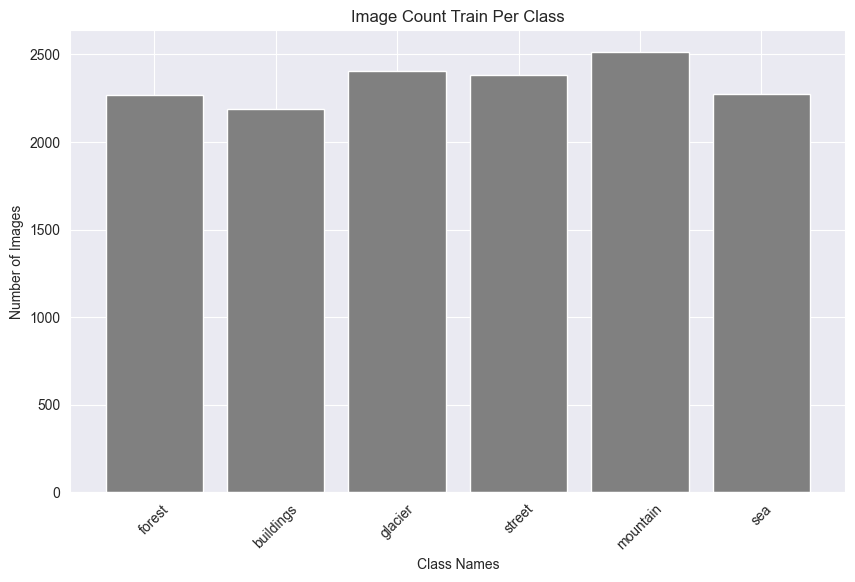

In [156]:
plt.figure(figsize=(10, 6))
plt.bar(train_class_counts.keys(), train_class_counts.values(), color='gray')
plt.title('Image Count Train Per Class')
plt.xlabel('Class Names')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

In [158]:
test_class_counts = {}
for class_name in os.listdir(test_path):
    class_dir = os.path.join(test_path, class_name)
    if os.path.isdir(class_dir):
        num_images = len(os.listdir(class_dir))
        test_class_counts[class_name] = num_images
for class_name, count in test_class_counts.items():
    print(f"{class_name}: {count} images")

forest: 474 images
buildings: 437 images
glacier: 553 images
street: 501 images
mountain: 525 images
sea: 510 images


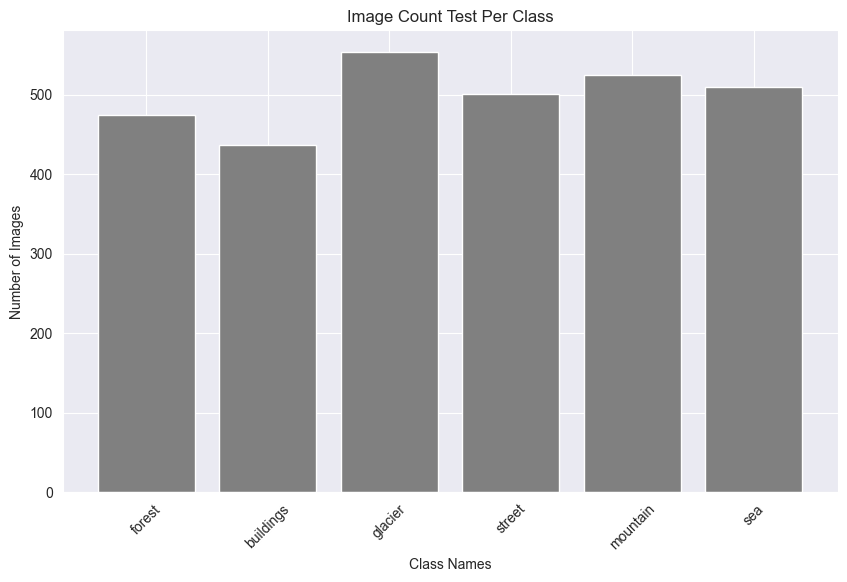

In [159]:
plt.figure(figsize=(10, 6))
plt.bar(test_class_counts.keys(), test_class_counts.values(), color='gray')
plt.title('Image Count Test Per Class')
plt.xlabel('Class Names')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

In [160]:
# Model architecture
model = Sequential()

# Normalization
model.add(Rescaling(1. / 255, input_shape=(150, 150, 1)))

# Convolutional layers 
model.add(Conv2D(32, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))

# Flatten and dense layers with Dropout
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(Dropout(0.4))
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.4))

# Output layer
model.add(Dense(units=len(class_train_names), activation='softmax'))

In [130]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_7 (Rescaling)         │ (None, 150, 150, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 146, 146, 32)   │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 146, 146, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 73, 73, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 69, 69, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 69, 69, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 34, 34, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 14, 14, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 512)            │     6,423,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,912,518 (26.37 MB)

 Trainable params: 6,911,558 (26.37 MB)

 Non-trainable params: 960 (3.75 KB)

In [161]:
# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    CSVLogger(os.path.join(LOG_DIR, 'training_log_v2.csv'), append=True)
]

# Train model
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)

# Save Model
model.save(MODEL_SAVE_PATH)

Epoch 1/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 253s 573ms/step - accuracy: 0.3534 - loss: 9.9257 - val_accuracy: 0.2893 - val_loss: 2.9626 - learning_rate: 0.0010
Epoch 2/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 251s 572ms/step - accuracy: 0.4994 - loss: 2.0588 - val_accuracy: 0.4160 - val_loss: 2.1048 - learning_rate: 0.0010
Epoch 3/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 249s 567ms/step - accuracy: 0.5619 - loss: 1.7772 - val_accuracy: 0.5547 - val_loss: 1.8133 - learning_rate: 0.0010
Epoch 4/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 249s 567ms/step - accuracy: 0.6150 - loss: 1.7292 - val_accuracy: 0.2343 - val_loss: 3.9018 - learning_rate: 0.0010
Epoch 5/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 251s 571ms/step - accuracy: 0.6588 - loss: 1.6473 - val_accuracy: 0.6060 - val_loss: 1.8146 - learning_rate: 0.0010
Epoch 6/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 254s 578ms/step - accuracy: 0.6883 - loss: 1.7207 - val_accuracy: 0.4663 - val_loss: 3.2661 - learning_rate: 0.0010
Epoch 7/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 253s 577ms/step - accura

In [162]:
# Evaluation and Report
test_loss, test_accuracy = model.evaluate(test_ds)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 120ms/step - accuracy: 0.8779 - loss: 0.6860
Test accuracy: 87.20%


In [163]:
# Evaluate the model on the training dataset
train_loss, train_accuracy = model.evaluate(train_ds)
print(f'Train accuracy: {train_accuracy * 100:.2f}%')

439/439 ━━━━━━━━━━━━━━━━━━━━ 56s 127ms/step - accuracy: 0.8925 - loss: 0.5937
Train accuracy: 89.10%


In [168]:
# Classification Report and Confusion Matrix
y_true = test_ds.classes
y_pred = np.argmax(model.predict(test_ds), axis=1)
print(classification_report(y_true, y_pred, target_names=test_ds.class_indices.keys()))

94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 117ms/step
              precision    recall  f1-score   support

   buildings       0.13      0.13      0.13       437
      forest       0.17      0.16      0.16       474
     glacier       0.19      0.18      0.19       553
    mountain       0.19      0.19      0.19       525
         sea       0.17      0.18      0.17       510
      street       0.17      0.18      0.17       501

    accuracy                           0.17      3000
   macro avg       0.17      0.17      0.17      3000
weighted avg       0.17      0.17      0.17      3000



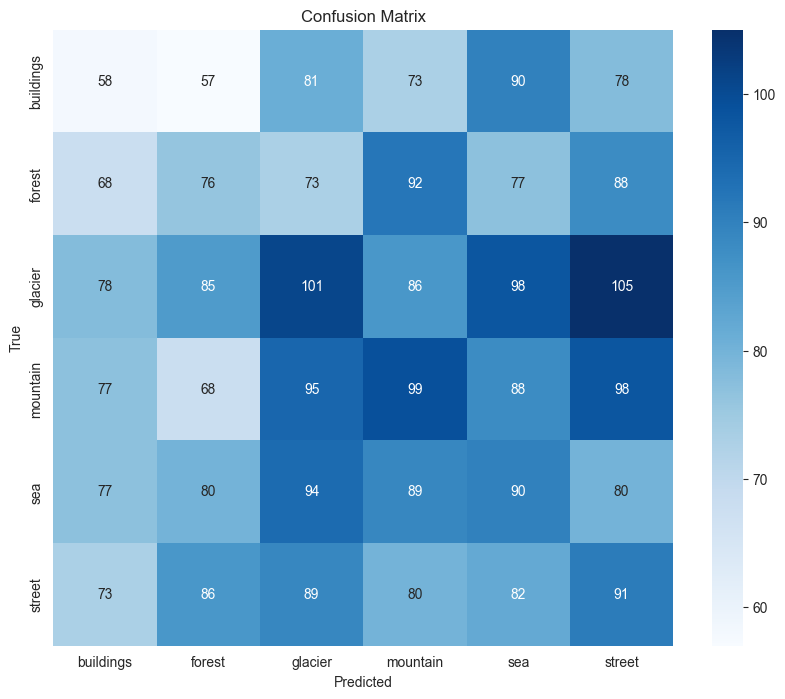

In [172]:
# Confusion Matrix Plot
conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=test_ds.class_indices.keys(),
            yticklabels=test_ds.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig(os.path.join(PLOT_SAVE_DIR, "confusion_matrix_v2.png"))
plt.show()

In [170]:
# Plotting Loss and Accuracy
def plot_metrics(history, metric, val_metric, title, y_label, save_path):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history[metric], label="Training")
    plt.plot(history.history[val_metric], label="Validation")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel(y_label)
    plt.legend()
    plt.grid(True)
    plt.savefig(save_path, format="png", dpi=300)
    plt.show()

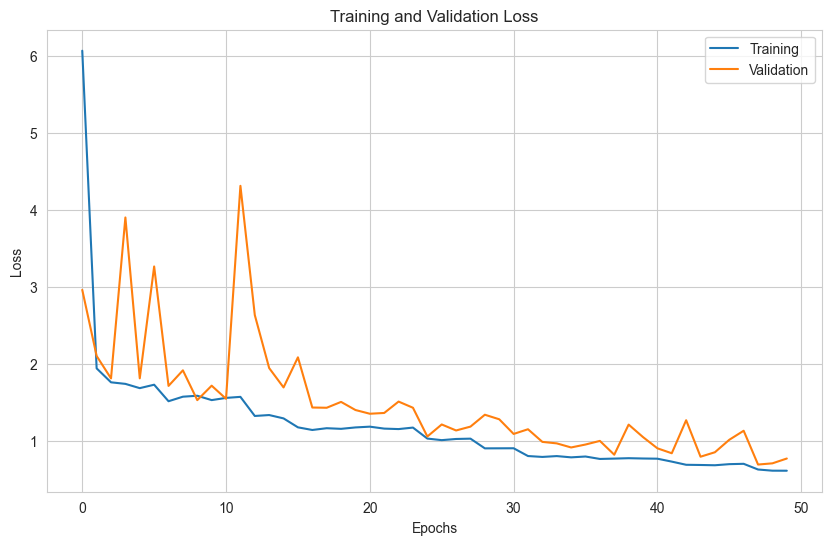

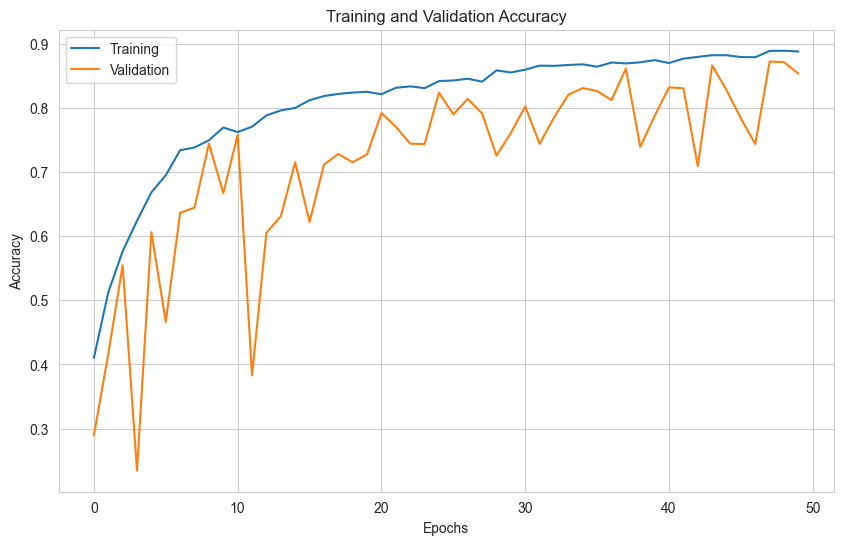

In [171]:
plot_metrics(history, 'loss', 'val_loss', "Training and Validation Loss", "Loss",
             os.path.join(PLOT_SAVE_DIR, "training_validation_loss_v2.png"))
plot_metrics(history, 'accuracy', 'val_accuracy', "Training and Validation Accuracy", "Accuracy",
             os.path.join(PLOT_SAVE_DIR, "training_validation_accuracy_v2.png"))

94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step


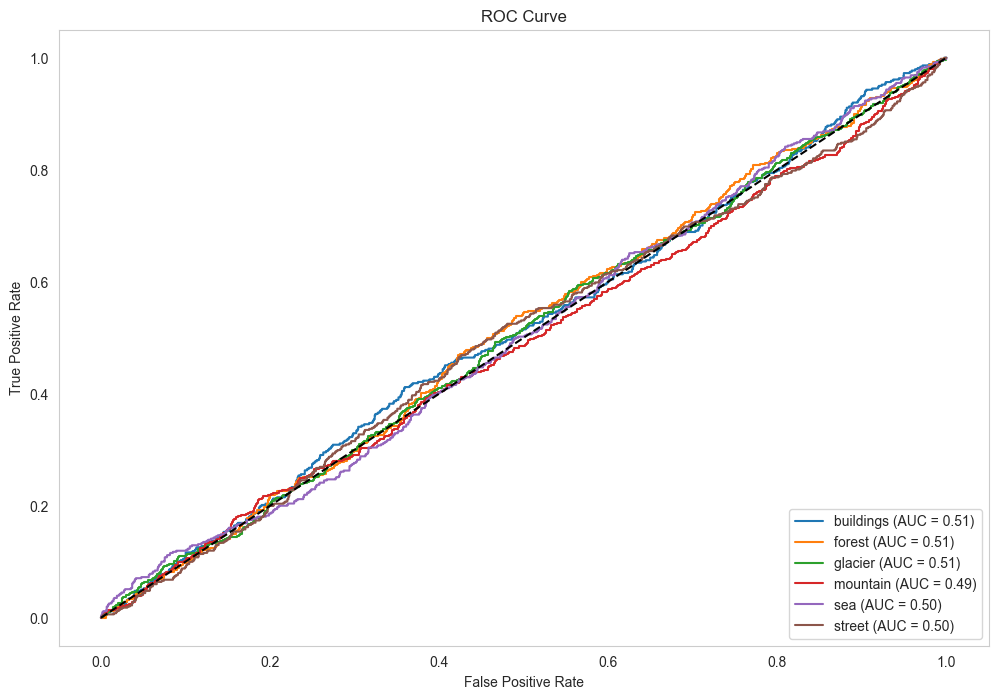

In [173]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the true labels for ROC curve (one-hot encoding)
y_true_bin = label_binarize(y_true, classes=list(range(len(test_ds.class_indices))))

# Get model probabilities
y_pred_prob = model.predict(test_ds)

# Plot ROC curve for each class
plt.figure(figsize=(12, 8))
for i, class_name in enumerate(test_ds.class_indices.keys()):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()